# WAI Computer Vision Workshop - Emotion Recognition

### Install & Import Libraries

Run the first cell if you are on anything but a MacBook with Apple Silicon (M1 or M2). If you are on a MacBook with Apple Silicon, you can skip the first cell and run the second cell.

In [1]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio numpy matplotlib mediapipe opencv-python

ERROR: Could not find a version that satisfies the requirement mediapipe (from versions: none)
ERROR: No matching distribution found for mediapipe

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio numpy matplotlib mediapipe-silicon opencv-python


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

### Setup Device

This code will ensure that later on we utilise a GPU or Macbook Silicon Accelerator if available. If not, it will use the CPU and you will experience longer training times.

In [4]:
# Check if GPU or MPS is available
DEVICE = torch.device("cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using:", DEVICE)


Using: mps


### Loading Dataset

The dataset is taken from [this](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge) Kaggle competition. We have converted it into simpler Numpy files so that it can be loaded in easier.

In [9]:
# Load train_x.npz and train_y.npz
raw_x = np.load('train_x.npz')['arr_0']
raw_y = np.load('train_y.npz')['arr_0']

print(raw_x.shape)
print(raw_y.shape)


(28709, 2304)
(28709,)


The labels are integers from 0 to 6 that correspond to emotions.

In [10]:
# Create a dictionary to map label to emotion
label_to_emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
                    3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


As you can see by running the cell below, there is not an equal number of images for each emotion. This will be important to keep in mind when we train our model.

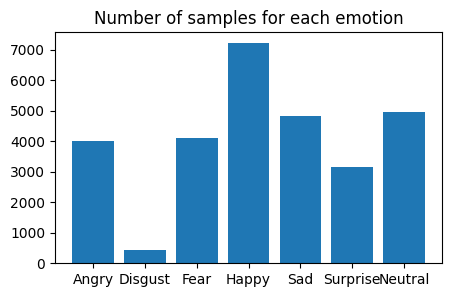

In [13]:
# Count number of samples for each emotion
emotion_count = {}
for label in np.unique(raw_y):
    emotion_count[label_to_emotion[label]] = np.count_nonzero(raw_y == label)

# Plot the number of samples for each emotion
plt.figure(figsize=(5, 3))
plt.bar(emotion_count.keys(), emotion_count.values())
plt.title('Number of samples for each emotion')
plt.show()



Running the cell below will show some examples of the images in the dataset. They are all grayscale images of 48x48 pixels.

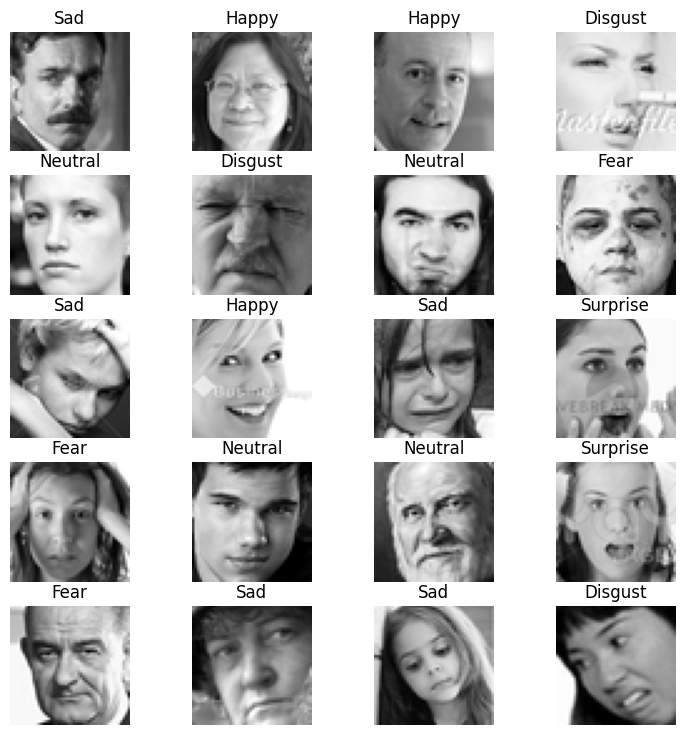

In [14]:
# Show 20 random images
plt.figure(figsize=(9, 9))
for i in range(20):
    random_index = np.random.randint(raw_x.shape[0])
    plt.subplot(5, 4, i + 1)
    plt.imshow(raw_x[random_index].reshape((48, 48)), cmap='gray')
    # Show label
    plt.title(label_to_emotion[raw_y[random_index]])
    plt.axis('off')
plt.show()


### Preprocessing

We must convert our data into a format that can be used for training. This includes putting the data into PyTorch tensors, splitting the data into training and validation sets, then finally creating data loaders for each set.

In [9]:
# Convert into torch dataset
x = torch.from_numpy(raw_x).float()
y = torch.from_numpy(raw_y).long()


In [10]:
# Shuffle the dataset
indices = torch.randperm(len(x))
x = x[indices]
y = y[indices]

# Split into train and test (we use 80% for training and 20% for testing)
train_x = x[:int(len(x)*0.8)]
train_y = y[:int(len(y)*0.8)]
test_x = x[int(len(x)*0.8):]
test_y = y[int(len(y)*0.8):]


In [11]:
# Reshape train_x and test_x to (1 x 48 x 48)
train_x = train_x.reshape(-1, 1, 48, 48)
test_x = test_x.reshape(-1, 1, 48, 48)

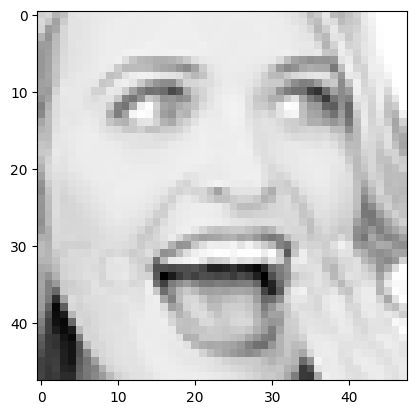

In [12]:
# Show one sample
plt.imshow(train_x[1].reshape(48, 48), cmap='gray')
plt.show()

### Model

We are using a simple CNN model for this. This task would improve with a more complex model, but we are keeping it simple for the sake of training compute time.

In [13]:
# Create a CNN model using PyTorch, that takes in (batch, 1 x 48 x 48) image, and outputs 7 classes

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12800, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
# Initialise model
model = CNN().to(DEVICE)

# Create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set config for training
EPOCHS = 60
BATCH_SIZE = 64

# Create a dataset and loader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Training

This is a fairly simple training loop

In [17]:
# Train the model
for epoch in range(EPOCHS):
    running_loss = 0
    running_num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to GPU or MPS
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()
        running_num_correct += (output.argmax(dim=1) == target).sum().item()

        # Print statistics every 100 mini-batches
        if batch_idx % 100 == 99:
            print('[%d, %5d] loss: %.3f, accuracy: %d %%' %
                  (epoch + 1, batch_idx + 1, running_loss / 100, 100 * running_num_correct / (BATCH_SIZE * 100)))
            running_loss = 0
            running_num_correct = 0

    # Every epoch, run validation
    with torch.no_grad():
        model.eval()

        correct = 0
        total = 0

        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        print('Accuracy of the network on the test images at epoch %d: %d %%' % (epoch + 1,
                                                                                 100 * correct / total))

        model.train()

# Save the model
torch.save(model.state_dict(), 'model.pth')


[1,   100] loss: 0.551, accuracy: 79 %
[1,   200] loss: 0.565, accuracy: 80 %
[1,   300] loss: 0.599, accuracy: 78 %
Accuracy of the network on the test images at epoch 1: 51 %
[2,   100] loss: 0.492, accuracy: 82 %
[2,   200] loss: 0.545, accuracy: 80 %
[2,   300] loss: 0.535, accuracy: 81 %
Accuracy of the network on the test images at epoch 2: 51 %
[3,   100] loss: 0.440, accuracy: 84 %
[3,   200] loss: 0.483, accuracy: 83 %


KeyboardInterrupt: 

Uncomment the code below, and run it to instead load the model from a checkpoint. This will save you from having to train the model again.

In [ ]:
# model = CNN()

# # Load the model
# model.load_state_dict(torch.load('model.pth'))

# # Move the model to the device
# model.to(DEVICE)

In [ ]:
# Test the model

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(test_loader.dataset),
                                                                100 * correct / total))


Accuracy of the network on the 5742 test images: 50 %


In [ ]:
# Use mediapipe to crop out the face from a webcam feed, and predict the emotion

import mediapipe as mp
import cv2

mp_drawing = mp.solutions.drawing_utils
mp_face_detection = mp.solutions.face_detection

# Load webcam feed
cap = cv2.VideoCapture(0)

# For each frame, show the face crop
with mp_face_detection.FaceDetection(
        min_detection_confidence=0.5) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        results = face_detection.process(image)

        # Draw the face detection annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        img_to_show = image.copy()
        if results.detections:
            for detection in results.detections:
                mp_drawing.draw_detection(image, detection)
                # Get the bounding box
                bbox = detection.location_data.relative_bounding_box

                # Get the face crop (bbox has xmin, ymin, width, height)
                face_crop = image[int(bbox.ymin * image.shape[0]):int((bbox.ymin + bbox.height) * image.shape[0]), int(
                    bbox.xmin * image.shape[1]):int(bbox.xmin * image.shape[1] + bbox.width * image.shape[1])]
                # Resize the face crop to 48 x 48
                face_crop = cv2.resize(face_crop, (48, 48))
                # Convert to grayscale
                face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)

                img_to_show = face_crop.copy()

                # Convert to float32
                face_crop = face_crop.astype(np.float32)
                # Normalize
                face_crop = face_crop / 255.0
                # Reshape to (1 x 1 x 48 x 48)
                face_crop = face_crop.reshape(1, 1, 48, 48)

                # Swap x and y axes
                # face_crop = np.swapaxes(face_crop, 2, 3)

                # Scale from [0, 1] to [0, 255]
                face_crop = face_crop * 255.0

                # Convert to tensor
                face_crop = torch.from_numpy(face_crop).float()
                # Move to GPU or MPS
                face_crop = face_crop.to(DEVICE)
                # Predict

                outputs = model(face_crop)
                _, predicted = torch.max(outputs.data, 1)
                print(label_to_emotion[predicted.item()])

                # Write predicted emotion on the image
                cv2.putText(image, label_to_emotion[predicted.item()], (int(bbox.xmin * image.shape[1]), int(
                    bbox.ymin * image.shape[0])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


        cv2.imshow('MediaPipe Face Detection', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break


Surprise
Fear
Surprise
Fear
Sad
Fear
Disgust
Sad
Fear
Sad
Neutral
Sad
Neutral
Sad
Sad
Sad
Sad
Neutral
Neutral
Fear
Sad
Sad
Neutral
Fear
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Sad
Fear
Sad
Neutral
Neutral
Sad
Neutral
Sad
Neutral
Neutral
Neutral
Happy
Sad
Neutral
Neutral
Surprise
Sad
Sad
Angry
Surprise
Angry
Sad
Sad
Surprise
Angry
Angry
Angry
Happy
Angry
Fear
Angry
Sad
Surprise
Sad
Fear
Surprise
Sad
Sad
Fear
Sad
Angry
Angry
Sad
Sad
Happy
Sad
Sad
Angry
Sad
Fear
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Neutral
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Sad
Happy
Happy
Happy
Happy
Happy
Happy
Sad
Happy
Happy
Happy
Happy
Happy
Happy
Sad
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happy
Happ

error: OpenCV(4.7.0) /Users/opencv-cn/GHA-OCV-1/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


: 